### Introduction

In this Jupyter notebook we will show how the libtimetag module can be used to import and process time-correlated single-photon counting (TCSPC) data.

The example data used here was used in the following publication:

Stijn O.M. Hinterding, Sander J.W. Vonk, Elleke J. van Harten, Freddy T. Rabouw, Dynamics of Intermittent Delayed Emission in Single CdSe/CdS Quantum Dots. *J. Phys. Chem. Lett.* **2020**, *11*, 4755--4761. https://dx.doi.org/10.1021/acs.jpclett.0c01250

### (Install libtimetag)

If you have not yet installed libtimetag, please do so by executing the following command in a suitable shell (e.g. the Anaconda Prompt):

    pip install libtimetag

### Import python modules

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import libtimetag as ltt
import numpy as np

### Import the data

We can obtain an experimental dataset to practice with from the libtimetag github page:

In [3]:
import urllib.request

url = "https://github.com/rabouwlab/libtimetag/raw/master/examples/example_data/example_data_QD02.zip"
urllib.request.urlretrieve(url,"./example_data_QD02.zip")

('./example_data_QD02.zip', <http.client.HTTPMessage at 0x202590b2520>)

Now unzip the data set

In [4]:
datadir = "./example_data_QD02/"

In [5]:
import zipfile
with zipfile.ZipFile("./example_data_QD02.zip",'r') as zip_ref:
    zip_ref.extractall(datadir)

These data were recorded on a single CdSe/CdS core/shell quantum dot (QD)

Now we import the data:

In [6]:
fn = "QD02_r_1.sstt"

In [7]:
exp_header,chan_headers,data=ltt.import_data(datadir+fn)

This dataset contains 3 valid channels:

1. Channel 2: Laser synchronization
2. Channel 3: Detector A
3. Channel 4: Detector B

(there are more channels present in the example data, these are not relevant now). Which channels are present in a dataset will depend on the experiment.

Upon importing the data, we have also imported the header information:

In [8]:
print(f"Time unit: {exp_header['Time_unit_seconds']:.2e} s")
print(f"Time-to-digital converter used: "+exp_header['device_type'])
print("Measurement started on: " + str(exp_header['experiment_start_timestamp_UTC']))

Time unit: 1.00e-12 s
Time-to-digital converter used: qutag
Measurement started on: 2019-09-02 13:39:24+00:00


In [9]:
timeunit = exp_header['Time_unit_seconds']

We also have information on each channel:

In [10]:
chan_headers[3]

{'ChannelID': 3,
 'Filename': 'QD02_r_1.sstt.c3',
 'NumPhotons': 2379926,
 'NumOverflows': 285,
 'Filesize': 14279604,
 'HardwareSyncDivider': 1,
 'AdditionalSyncDivider': 1,
 'TotalSyncDivider': 1,
 'IsPulsesChannel': False,
 'HasPulsesChannel': True,
 'CorrespondingPulsesChannel': 2,
 'HasMicrotimes': False,
 'MicroDelayTime': 0,
 'PulsePeriod': 0}

In [11]:
# Let's store the relevant data in dedicated variables
macro3=data[3]['macro']
macro4=data[4]['macro']
micro3=data[3]['micro']
micro4=data[4]['micro']

### Intensity trace (blinking trace)

In [12]:
macrobins = np.arange(macro3[0],macro3[-1],10e-3/timeunit)

In [13]:
macrohist3,_ = np.histogram(macro3,macrobins)
macrohist4,_ = np.histogram(macro4,macrobins)

Text(0, 0.5, 'PL intensity (cts/10 ms)')

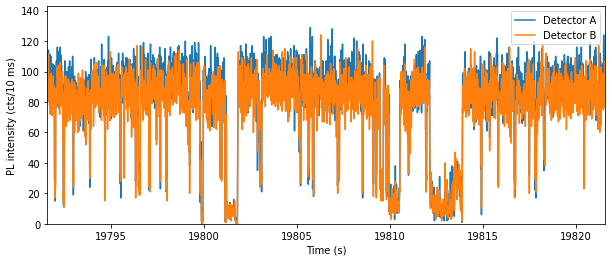

In [14]:
f,ax = plt.subplots(figsize=(10,4))

ts = (macrobins[1:]+macrobins[:-1])/2*timeunit
ax.plot(ts,macrohist3,label="Detector A")
ax.plot(ts,macrohist4,label="Detector B")

ax.set_ylim(0,)
ax.set_xlim(ts[0],ts[0]+30)
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("PL intensity (cts/10 ms)")

### Time-resolved data: decay curves

In [15]:
microbins = np.arange(0,2000e-9/timeunit,.5e-9/timeunit)

The 'microtimes', i.e. the photon arrival times relative to the laser pulse, are automatically generated for relevant channels when the data is imported.

In [16]:
microhist3,_ = np.histogram(micro3,microbins)
microhist4,_ = np.histogram(micro4,microbins)

(0.0, 1000.0)

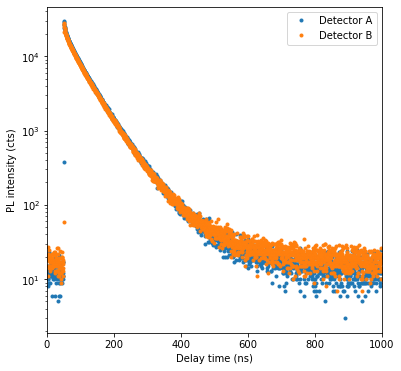

In [17]:
f,ax = plt.subplots(figsize=(6,6))

ax.plot((microbins[1:]+microbins[:-1])/2/1e3,microhist3,'.',label="Detector A")
ax.plot((microbins[1:]+microbins[:-1])/2/1e3,microhist4,'.',label="Detector B")

ax.legend()
ax.set_yscale('log')

ax.set_xlabel("Delay time (ns)")
ax.set_ylabel("PL intensity (cts)")

ax.set_xlim(0,1e3)

### Cross-correlation function: anti-bunching

We can prove that we are studying a single emitter by performing cross-correlation. When the zero-delay peak is decreased in intensity relative to the side peaks, or completely absent (i.e., anti-bunching) then we know that we are observing an individual single-photon emitter. 

In [18]:
corr_bins = np.arange(-3.5e-6/timeunit,3.5e-6/timeunit)

In [19]:
# Do the correlation
corr = ltt.correlate_lin(corr_bins,macro3,macro4)

# Rebin to decrease noise.
rebin_val = 1000 # X-time unit: 40 ns
corr_ = ltt.rebin(corr,rebin_val)
corr_bins_ = ltt.rebin_bin_edges(corr_bins,rebin_val)

# Rebin to decrease noise.
rebin_val2 = 1000 # X-time unit: 2 ns
corr2_ = ltt.rebin(corr,rebin_val2)
corr_bins2_ = ltt.rebin_bin_edges(corr_bins,rebin_val2)

Text(0.5, 0, 'Lag time $\\tau$ (ns)')

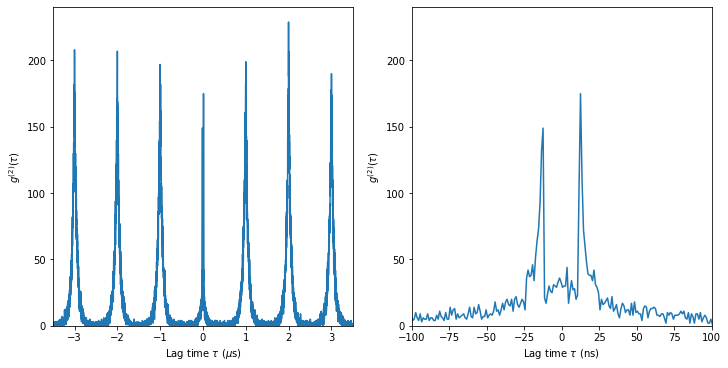

In [20]:
f,axes = plt.subplots(ncols=2,figsize=(10,5),constrained_layout=True)

ax = axes[0]
ax.plot((corr_bins_[1:]+corr_bins_[:-1])/2*1e-6,corr_)

ax.set_ylim(0)
ax.set_xticks([-3,-2,-1,0,1,2,3])

ax.set_xlim(-3.5,3.5)
ax.set_ylabel(r"$g^\mathrm{(2)}(\tau)$")
ax.set_xlabel(r"Lag time $\tau$ ($\mu$s)")


ax = axes[1]
ax.plot((corr_bins2_[1:]+corr_bins2_[:-1])/2*1e-3,corr2_)

ax.set_ylim(0,)
ax.set_xlim(-100,100)
ax.set_ylabel(r"$g^\mathrm{(2)}(\tau)$")
ax.set_xlabel(r"Lag time $\tau$ (ns)")

The central 'peak' consists in fact of two peaks, which are due to detector *afterglow*: our avalanche photodiodes sometimes *emit* photons after they have detected a photon. These photons travel back through the setup, reflect off the sample, and can then be detected by the other detector.

The interested reader may be able to deduce the length of the optical path from these data.

### Cross-correlation function: longer timescales

Cross-correlation on longer timescales tells us something about the timescale of blinking. See also:

Freddy T. Rabouw, Felipe V. Antolinez, Raphael Brechbühler, David J. Norris, *J. Phys. Chem. Lett.* **2019**, *10*, 3732--3738. https://doi.org/10.1021/acs.jpclett.9b01348

A similar approach is used in biochemistry and biophysics to study diffusion of fluorescent molecules (fluorescence correlation spectroscopy, FCS).

In [21]:
corr_bins_log = np.logspace(np.log10(1e-9/timeunit),np.log10(10/timeunit),150)

In [22]:
corr_hist_log = ltt.correlate_fcs(corr_bins_log,macro3,macro4)

In [23]:
# We should also normalize the correlation curve
T_min = np.min(np.append(macro3,macro4))
T_max = np.max(np.append(macro3,macro4))

corr_norm = ltt.norm_corr(corr_hist_log,corr_bins_log,T_min,T_max,len(macro3),len(macro4))

Text(0, 0.5, '$g^\\mathrm{(2)}(\\tau)$')

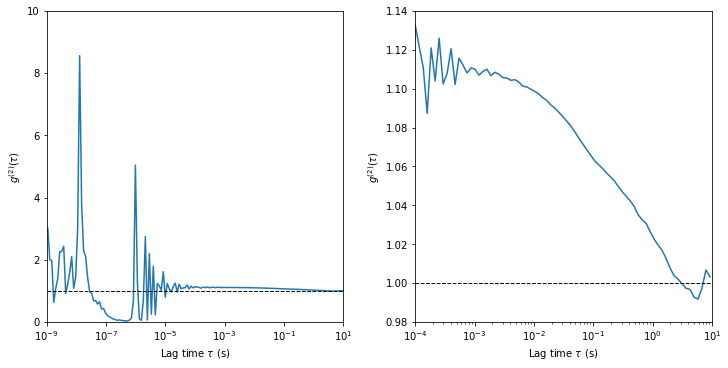

In [24]:
f,axes = plt.subplots(figsize=(10,5),ncols=2,constrained_layout=True)

ts = (corr_bins_log[1:]+corr_bins_log[:-1])/2*timeunit

ax = axes[0]
ax.plot(ts,corr_norm)
ax.set_xscale('log')
ax.set_xlim(1e-9,10)
ax.set_ylim(0,10)
ax.plot(ax.get_xlim(),[1,1],'--',c='k',linewidth=1)

ax.set_xlabel(r"Lag time $\tau$ (s)")
ax.set_ylabel(r"$g^\mathrm{(2)}(\tau)$")

ax = axes[1]
ax.plot(ts,corr_norm)
ax.set_xscale('log')
ax.set_xlim(1e-4,10)
ax.set_ylim(0.98,1.14)
ax.plot(ax.get_xlim(),[1,1],'--',c='k',linewidth=1)

ax.set_xlabel(r"Lag time $\tau$ (s)")
ax.set_ylabel(r"$g^\mathrm{(2)}(\tau)$")

After proper normalization the correlation curve goes to unity with increasing lag times.